## **Predicting Cirrhosis Outcomes**


**Overview**: Cirrhosis is a critical liver condition, and predicting patient outcomes can play a vital role in improving healthcare strategies and interventions. This dataset provides detailed demographic, clinical, and health-related information about patients with cirrhosis.

**Goal**: To build a multi-class classification model to predict patient outcomes based on the available features.

In [34]:
#load the needed libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from scipy.stats import uniform, randint
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings('ignore')

In [35]:
train = pd.read_csv('train.csv')
train.head()

,id,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
0,0,1690.0,Placebo,16714.0,F,N,Y,Y,N,14.4,514.0,3.16,42.0,2184.0,185.00,126.0,319.0,13.2,4.0,D
1,1,2216.0,D-penicillamine,19327.0,F,Y,Y,N,N,1.3,NaN,3.03,234.0,601.0,135.00,NaN,559.0,11.5,4.0,D
2,2,1725.0,Placebo,12897.0,F,N,N,N,N,0.8,232.0,3.85,9.0,1074.0,128.65,99.0,295.0,9.5,3.0,C
3,3,2468.0,D-penicillamine,20555.0,F,N,N,Y,N,0.5,176.0,3.61,121.0,558.0,96.10,55.0,151.0,11.0,3.0,C
4,4,999.0,D-penicillamine,26580.0,M,N,N,N,N,1.8,318.0,3.52,73.0,721.0,85.25,260.0,NaN,9.6,2.0,C


#### Dataset description
Key Details:
- Target variable: Status (patient outcome – censored, censored due to liver transplant, or death)
- Features: Include demographic attributes (age, sex), clinical signs (ascites, hepatomegaly, edema), and laboratory test results (bilirubin, albumin, alkaline phosphatase, etc.)

Variables:
- ID: Unique identifier for each patient
- N_Days: Number of days from registration to the event (death, transplant, or end of study)
- Status: Patient outcome (C = censored, CL = censored due to liver transplant, D = death)
- Drug: Type of drug (D-penicillamine or placebo)
- Age: Patient age in days
- Sex: Male (M) or Female (F)
- Ascites: Presence of fluid in the abdomen (Yes/No)
- Hepatomegaly: Enlarged liver (Yes/No)
- Spiders: Presence of blood vessel malformations (Yes/No)
- Edema: Edema status (N=no edema and no diuretic therapy for edema, S=edema present without diuretics or edema resolved by diuretics, Y=edema despite diuretics therapy)
- Bilirubin: Serum bilirubin (mg/dl)
- Cholesterol: Serum cholesterol (mg/dl)
- Albumin: Albumin level (gm/dl)
- Copper: Urine copper (µg/day)
- Alk_Phos: Alkaline phosphatase (U/liter)
- SGOT: Serum glutamic-oxaloacetic transaminase (U/ml)
- Triglycerides: Serum triglycerides
- Platelets: Platelet count (per 1000 ml)
- Prothrombin: Prothrombin time (seconds)
- Stage: Histologic stage of disease (1–3)

In [36]:
#info about the dataset
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             15000 non-null  int64  
 1   N_Days         15000 non-null  float64
 2   Drug           8492 non-null   object 
 3   Age            15000 non-null  float64
 4   Sex            15000 non-null  object 
 5   Ascites        8494 non-null   object 
 6   Hepatomegaly   8487 non-null   object 
 7   Spiders        8485 non-null   object 
 8   Edema          15000 non-null  object 
 9   Bilirubin      15000 non-null  float64
 10  Cholesterol    6612 non-null   float64
 11  Albumin        15000 non-null  float64
 12  Copper         8364 non-null   float64
 13  Alk_Phos       8485 non-null   float64
 14  SGOT           8480 non-null   float64
 15  Tryglicerides  6560 non-null   float64
 16  Platelets      14429 non-null  float64
 17  Prothrombin    14979 non-null  float64
 18  Stage 

In [37]:
#statistical summary of the dataset
train.describe()

,id,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
count,15000.000000,15000.000000,15000.000000,15000.000000,6612.000000,15000.000000,8364.000000,8485.000000,8480.000000,6560.000000,14429.000000,14979.000000,15000.000000
mean,7499.500000,1970.903067,19271.966733,1.881873,324.806745,3.517281,75.857006,1629.738417,106.603055,111.827439,253.632261,10.636691,3.029000
std,4330.271354,1272.532950,3732.634877,2.790137,172.087714,0.372396,74.839986,1836.475288,51.787553,50.801406,93.050690,0.745795,0.883597
min,0.000000,10.000000,244.000000,0.300000,17.200000,1.860000,2.000000,2.770000,0.900000,33.000000,0.900000,9.000000,1.000000
25%,3749.750000,1092.000000,16467.000000,0.600000,239.000000,3.290000,31.000000,721.000000,71.000000,80.000000,182.000000,10.100000,2.000000
50%,7499.500000,1790.000000,19544.000000,0.900000,280.000000,3.570000,52.000000,1072.000000,97.650000,100.000000,249.000000,10.600000,3.000000
75%,11249.250000,2644.000000,22336.000000,1.800000,358.000000,3.770000,89.000000,1653.000000,133.300000,135.000000,312.000000,11.000000,4.000000
max,14999.000000,25569.000000,94306.000000,28.000000,2880.000000,4.640000,588.000000,18733.000000,601.350000,598.000000,721.000000,20.000000,4.000000


**Data Preprocessing**

In [38]:
train.isna().sum()

id                  0
N_Days              0
Drug             6508
Age                 0
Sex                 0
Ascites          6506
Hepatomegaly     6513
Spiders          6515
Edema               0
Bilirubin           0
Cholesterol      8388
Albumin             0
Copper           6636
Alk_Phos         6515
SGOT             6520
Tryglicerides    8440
Platelets         571
Prothrombin        21
Stage               0
Status              0
dtype: int64

In [39]:
#drop the columsn with alot of missing values and those that are not needed for the analysis
train.drop(['Drug', 'Ascites', 'Hepatomegaly', 'Spiders', 'Cholesterol', 'Copper','Alk_Phos', 'SGOT','Tryglicerides'], axis=1, inplace=True)

In [40]:
#fill the missing values with the median of each column
train['Platelets'].fillna(train['Platelets'].median(), inplace=True)
train['Prothrombin'].fillna(train['Prothrombin'].median(), inplace=True)

In [41]:
train.isna().sum()

id             0
N_Days         0
Age            0
Sex            0
Edema          0
Bilirubin      0
Albumin        0
Platelets      0
Prothrombin    0
Stage          0
Status         0
dtype: int64

In [42]:
#convert the age column to years for better understanding
train['Age'] = train['Age'] / 365
train['Age'] = train['Age'].round(1)



In [43]:
#check for outliers in the age column
q1 = train['Age'].quantile(0.25)
q3 = train['Age'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr 
outliers = train[(train['Age'] < lower_bound) | (train['Age'] > upper_bound)]
outliers

,id,N_Days,Age,Sex,Edema,Bilirubin,Albumin,Platelets,Prothrombin,Stage,Status
618,618,1293.0,3.5,F,N,1.0,3.60,252.0,10.3,3.0,C
785,785,3336.0,258.4,F,N,1.0,3.45,336.0,11.0,3.0,D
1451,1451,3445.0,0.7,F,N,1.6,3.48,311.0,10.4,4.0,C
1712,1712,1236.0,3.8,F,N,1.0,3.57,166.0,10.4,3.0,C
2046,2046,2995.0,8.2,F,N,0.8,3.82,399.0,11.7,2.0,D
3044,3044,1097.0,7.7,F,N,0.7,3.73,256.0,10.8,1.0,C
3751,3751,3468.0,9.5,F,N,0.6,3.93,209.0,9.9,2.0,C
4410,4410,3445.0,9.5,F,N,0.9,3.83,306.0,10.6,4.0,C
4997,4997,1447.0,7.1,F,S,2.1,3.35,136.0,12.0,4.0,D
5262,5262,2301.0,17.7,F,N,1.3,3.30,234.0,11.0,3.0,C


In [44]:
#filter out the outliers in the age column i.e age less than 10 years and greater than 120 years
train = train[(train['Age'] >= 10.0) & (train['Age'] <= 120.0)]

**Explanatory Data Analysis**

<i>Target variable Distribution</i>

In [45]:
# Target variable Distribution

fig = px.histogram(train, 
                   x='Status', 
                   color='Status',
                   title='Distribution of patient Outcomes (Status)',
                   labels={'Status':'outcome', 'count':'Number of Patients'},
                   text_auto=True, 
                   color_discrete_sequence=px.colors.qualitative.Set2)

fig.update_layout(title_font_size=18,
                  xaxis=dict(title='Outcome'),
                  yaxis=dict(title='Number of Patients'),
                  bargap=0.2,
                  template='simple_white')
fig.show()


In [101]:
# Example for one of your Plotly figures
fig.write_html("plot.html")


- From the distribution of target variables above, the number of patients who **censored** was the highest then followed by the number of patients who died then the number of patients who censored due to a liver transplant.
- There is a class imbalance for the target variable

<i>Age vs Outcome</i>

In [46]:
# Age vs Outcome
fig = px.box(train, 
            y='Age',
            color='Status',
            title='Age Distribution by Patient Outcomes',
            labels={'Age':'Age (years)', 'Status':'Outcome'},
            color_discrete_sequence=px.colors.qualitative.Set2)

fig.update_layout(title_font_size=18,
                  yaxis=dict(title='Age (years)'),
                  template='simple_white')
fig.show()

- From the above  boxplot, Age distribution differs by outcome: deaths span a broader and older range, while survivors and transplanted patients cluster in middle age.

<i>Clinical features vs Outcome</i>

In [47]:
# Distribution of other 4 important clinical features vs Outcome
clinical_features = ['Bilirubin', 'Albumin', 'Prothrombin', 'Platelets']
for feature in clinical_features:
    fig = px.box(train, 
                y=feature,
                color='Status',
                title=f'{feature} Distribution by Patient Outcomes',
                labels={feature:feature, 'Status':'Outcome'},
                color_discrete_sequence=px.colors.qualitative.Set2)

    fig.update_layout(title_font_size=18,
                    yaxis=dict(title=feature),
                    template='simple_white')
    fig.show()


<i>Categorical features vs Outcomes</i>

In [48]:
categorical_features = ['Sex', 'Edema']
for feature in categorical_features:
    fig = px.histogram(train, 
                       x=feature, 
                       color='Status',
                       barmode='group',
                       title=f'Distribution of {feature} by Patient Outcomes',
                       labels={feature:feature, 'count':'Number of Patients', 'Status':'Outcome'},
                       text_auto=True, 
                       color_discrete_sequence=px.colors.qualitative.Set2)

    fig.update_layout(title_font_size=18,
                      xaxis=dict(title=feature),
                      yaxis=dict(title='Number of Patients'),
                      bargap=0.2,
                      template='simple_white')
    fig.show()

- From the graph showing the distribution of the status and the gender; the females were the most who `censored` as compared to the males. Then also the majority of the females `died` as compared to the males.
- From the second graph showing the distribution of the status and Edema; majority of the patient had no edema and also no diuretic therapy for edema.

**Modelling**

In [49]:
#log transformations for the clinical results to reduce skewness
train['Bilirubin_log'] = np.log1p(train['Bilirubin'])
train['Prothrombin_log'] = np.log1p(train['Prothrombin'])
train['Platelets_log'] = np.log1p(train['Platelets'])

In [50]:
train.head()

,id,N_Days,Age,Sex,Edema,Bilirubin,Albumin,Platelets,Prothrombin,Stage,Status,Bilirubin_log,Prothrombin_log,Platelets_log
0,0,1690.0,45.8,F,N,14.4,3.16,319.0,13.2,4.0,D,2.734368,2.653242,5.768321
1,1,2216.0,53.0,F,N,1.3,3.03,559.0,11.5,4.0,D,0.832909,2.525729,6.327937
2,2,1725.0,35.3,F,N,0.8,3.85,295.0,9.5,3.0,C,0.587787,2.351375,5.690359
3,3,2468.0,56.3,F,N,0.5,3.61,151.0,11.0,3.0,C,0.405465,2.484907,5.023881
4,4,999.0,72.8,M,N,1.8,3.52,249.0,9.6,2.0,C,1.029619,2.360854,5.521461


In [51]:
#drop the original columns after log transformation
train = train.drop(columns=['Bilirubin', 'Prothrombin', 'Platelets'], axis=1)

In [52]:
#encoding for categorical variables
train['Edema'] = train['Edema'].map({'N': 0, 'S': 1, 'Y': 2})

In [53]:
#encoding the target variable
train['Status'] = train['Status'].map({'D': 0, 'CL':1, 'C':2})

In [54]:
#encode the sex column
train['Sex'] = train['Sex'].map({'M': 0, 'F': 1})

In [55]:
train.head()

,id,N_Days,Age,Sex,Edema,Albumin,Stage,Status,Bilirubin_log,Prothrombin_log,Platelets_log
0,0,1690.0,45.8,1,0,3.16,4.0,0,2.734368,2.653242,5.768321
1,1,2216.0,53.0,1,0,3.03,4.0,0,0.832909,2.525729,6.327937
2,2,1725.0,35.3,1,0,3.85,3.0,2,0.587787,2.351375,5.690359
3,3,2468.0,56.3,1,0,3.61,3.0,2,0.405465,2.484907,5.023881
4,4,999.0,72.8,0,0,3.52,2.0,2,1.029619,2.360854,5.521461


In [56]:
#scale the data
num_col = ['N_Days','Age', 'Bilirubin_log', 'Albumin', 'Prothrombin_log', 'Platelets_log']
scaler = StandardScaler()
train[num_col] = scaler.fit_transform(train[num_col])


In [57]:
#split the data into features and target variable
X = train.drop('Status', axis=1)
y = train['Status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [58]:
#apply smote to balance the datasets
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)

Logistic regression

In [59]:
#used the class weight to balance the classes
log_reg = LogisticRegression(class_weight='balanced', max_iter=200)
log_reg.fit(X_train, y_train)
# Make predictions
y_pred = log_reg.predict(X_test)

# Evaluate the model
print("Logistic Regression Model")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("classification report:\n", classification_report(y_test, y_pred))

Logistic Regression Model
Accuracy: 0.736648865153538
Confusion Matrix:
 [[ 637  120  151]
 [  11   41   18]
 [ 214  275 1529]]
classification report:
               precision    recall  f1-score   support

           0       0.74      0.70      0.72       908
           1       0.09      0.59      0.16        70
           2       0.90      0.76      0.82      2018

    accuracy                           0.74      2996
   macro avg       0.58      0.68      0.57      2996
weighted avg       0.83      0.74      0.78      2996



In [60]:
#applied smote to balance data
log_reg = LogisticRegression()
param_grid = { 'C': uniform(0.01, 10),   # inverse of regularization strength
    'penalty': ['l1', 'l2'] }  # regularization type

#stratified cv
strat_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#randomized cv
random_search = RandomizedSearchCV(log_reg,
                                   param_grid,
                                   n_iter=20,                
                                    scoring='f1_weighted',   
                                    cv=strat_cv,
                                    verbose=1,
                                     n_jobs=-1,
                                     random_state=42)
random_search.fit(X_res, y_res)
# Make predictions
y_pred = random_search.predict(X_test)

# Evaluate the model
print("Logistic Regression Model")
print ("Best hyperparameters: ",random_search.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("classification report:\n", classification_report(y_test, y_pred))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Logistic Regression Model
Best hyperparameters:  {'C': 6.193860093330873, 'penalty': 'l2'}
Accuracy: 0.7363150867823764
Confusion Matrix:
 [[ 643  102  163]
 [  14   36   20]
 [ 225  266 1527]]
classification report:
               precision    recall  f1-score   support

           0       0.73      0.71      0.72       908
           1       0.09      0.51      0.15        70
           2       0.89      0.76      0.82      2018

    accuracy                           0.74      2996
   macro avg       0.57      0.66      0.56      2996
weighted avg       0.82      0.74      0.77      2996



Insights
- Accuracy: stayed the same (~73.6%).
- Class 0: recall improved slightly (0.70 → 0.71), precision stayed stable.
- Class 1: performance dropped — recall decreased (0.59 → 0.51), f1 fell slightly (0.16 → 0.15).
- Class 2: performance remained the same (recall = 0.76, f1 = 0.82).
Overall: Hyperparameter tuning did not improve the model — results are essentially the same especially for minority class (Class 1).

Therefore, these suggests that Logistic Regression struggle with the class imbalance in my data. So moving to more flexible models (RF, XGBoost) could yield better improvements than tuning LR hyperparameters.

Random Forest Classifier

In [61]:
#used the class weight to balance the classes
rf = RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

# Evaluate the model
print("Random Forest Model")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("classification report:\n", classification_report(y_test, y_pred_rf))

Random Forest Model
Accuracy: 0.8374499332443258
Confusion Matrix:
 [[ 618    2  288]
 [  21    2   47]
 [ 126    3 1889]]
classification report:
               precision    recall  f1-score   support

           0       0.81      0.68      0.74       908
           1       0.29      0.03      0.05        70
           2       0.85      0.94      0.89      2018

    accuracy                           0.84      2996
   macro avg       0.65      0.55      0.56      2996
weighted avg       0.82      0.84      0.83      2996



In [62]:
# Apply SMOTE to balance the classes
rf = RandomForestClassifier()

param_grid = {'n_estimators': randint(100, 500),       # number of trees
    'max_depth': randint(3, 15),             # max depth per tree
    'min_samples_split': randint(2, 10),     # min samples to split a node
    'min_samples_leaf': randint(1, 5),       # min samples at a leaf
    'max_features': ['auto', 'sqrt', 'log2']}
# stratified k fold
stra_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rs = RandomizedSearchCV(rf, 
                        param_grid, 
                        n_iter=20,
                        scoring='f1_weighted',
                        cv=stra_cv,
                        verbose=1,
                        n_jobs=-1,
                        random_state=42)

rs.fit(X_res, y_res)
y_pred_rf = rs.predict(X_test)
# Evaluate the model
print("Random Forest Model after SMOTE")
print("The best hyperparameter, ", rs.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("classification report:\n", classification_report(y_test, y_pred_rf))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Random Forest Model after SMOTE
The best hyperparameter,  {'max_depth': 14, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 7, 'n_estimators': 369}
Accuracy: 0.8160881174899867
Confusion Matrix:
 [[ 664   33  211]
 [  20   17   33]
 [ 187   67 1764]]
classification report:
               precision    recall  f1-score   support

           0       0.76      0.73      0.75       908
           1       0.15      0.24      0.18        70
           2       0.88      0.87      0.88      2018

    accuracy                           0.82      2996
   macro avg       0.60      0.62      0.60      2996
weighted avg       0.83      0.82      0.82      2996



Insights
- Accuracy dropped slightly (0.84 → 0.82) after tuning + SMOTE.
- Class 0 improved in recall and balance.
- Class 1 (minority class) improved significantly (recall 0.03 → 0.24, f1 0.05 → 0.18), showing that SMOTE + tuning helped address imbalance.
- Class 2 (majority class) declined a little in recall (0.94 → 0.87), which is expected when balancing trade-offs.

The RF maximized overall accuracy by favouring the majority class, but tuned RF with SMOTE balanced class performance better, especially for the underrepresented class 1. This makes the RF useful for imbalanced classification tasks, even with a small sacrifice in accuarcy.

Gradient Boosting Classifier

In [63]:
#applied the class weight to balance the classes
num_negative = len(y_res) - sum(y_res == 1)
num_positive = sum(y_res == 1)
scale_pos_weight_1 = num_negative / num_positive

xg = XGBClassifier(
    use_label_encoder=False,
    eval_metric='mlogloss',
    scale_pos_weight=scale_pos_weight_1,
    max_depth=2,
    learning_rate=0.03,
    n_estimators=250,
    subsample=0.4,
    colsample_bytree=0.4,
    reg_alpha=0.01,
    reg_lambda=1)
xg.fit(X_train, y_train)

y_pred_xg = xg.predict(X_test)

print("XGBoost Classifier:")
print("accuracy: ", accuracy_score(y_test, y_pred_xg))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xg))
print("Classicifaction report:\n", classification_report(y_test, y_pred_xg))

XGBoost Classifier:
accuracy:  0.8401201602136181
Confusion Matrix:
 [[ 625    0  283]
 [  22    0   48]
 [ 126    0 1892]]
Classicifaction report:
               precision    recall  f1-score   support

           0       0.81      0.69      0.74       908
           1       0.00      0.00      0.00        70
           2       0.85      0.94      0.89      2018

    accuracy                           0.84      2996
   macro avg       0.55      0.54      0.55      2996
weighted avg       0.82      0.84      0.83      2996



In [ ]:
#applied the smote to balance the classes
num_negative = len(y_res) - sum(y_res == 1)
num_positive = sum(y_res == 1)
scale_pos_weight_1 = num_negative / num_positive

xg = XGBClassifier(
    use_label_encoder=False,
    eval_metric='mlogloss',
    scale_pos_weight=scale_pos_weight_1,
    max_depth=2,
    learning_rate=0.03,
    n_estimators=250,
    subsample=0.4,
    colsample_bytree=0.4,
    reg_alpha=0.01,
    reg_lambda=1)
xg.fit(X_res, y_res)

y_pred_xg = xg.predict(X_test)

print("XGBoost Classifier:")
print("accuracy: ", accuracy_score(y_test, y_pred_xg))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xg))
print("Classicifaction report:\n", classification_report(y_test, y_pred_xg))

XGBoost Classifier:
accuracy:  0.7893858477970628
Confusion Matrix:
 [[ 667   78  163]
 [  15   32   23]
 [ 197  155 1666]]
Classicifaction report:
               precision    recall  f1-score   support

           0       0.76      0.73      0.75       908
           1       0.12      0.46      0.19        70
           2       0.90      0.83      0.86      2018

    accuracy                           0.79      2996
   macro avg       0.59      0.67      0.60      2996
weighted avg       0.84      0.79      0.81      2996



In [64]:
#apply smote to balance the datasets

xg = XGBClassifier(use_label_encoder=False,
    eval_metric='mlogloss',
    scale_pos_weight=None)

param_grid = {'n_estimators': randint(100, 400),
    'max_depth': randint(3, 8),
    'learning_rate': uniform(0.01, 0.2),
    'subsample': uniform(0.5, 0.5),       # 0.5 to 1.0
    'colsample_bytree': uniform(0.5, 0.5),# 0.5 to 1.0
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0, 1)}
#stratified kfold
strat_cv2 = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rs1 = RandomizedSearchCV(xg,
                        param_grid,  
                        n_iter=20,
                        scoring='f1_weighted',
                        cv=strat_cv2,
                        verbose=1,
                        n_jobs=-1,
                        random_state=42)
rs1.fit(X_res, y_res)

y_pred = rs1.predict(X_test)
print("XGBoost Classifier with scale_pos_weight:")
print("The best hyperparameters: ", rs1.best_params_)
print("accuracy: ", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classicifaction report:\n", classification_report(y_test, y_pred))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
XGBoost Classifier with scale_pos_weight:
The best hyperparameters:  {'colsample_bytree': 0.8645035840204937, 'learning_rate': 0.16425406933718917, 'max_depth': 7, 'n_estimators': 330, 'reg_alpha': 0.6510770255019445, 'reg_lambda': 0.9149596755437808, 'subsample': 0.9250192888948996}
accuracy:  0.8381174899866488
Confusion Matrix:
 [[ 656   15  237]
 [  25    7   38]
 [ 156   14 1848]]
Classicifaction report:
               precision    recall  f1-score   support

           0       0.78      0.72      0.75       908
           1       0.19      0.10      0.13        70
           2       0.87      0.92      0.89      2018

    accuracy                           0.84      2996
   macro avg       0.62      0.58      0.59      2996
weighted avg       0.83      0.84      0.83      2996



Insights
- Accuracy stayed nearly the same (0.84 → 0.84).
- Class 0 improved in recall and f1.
- Class 1 (minority class) improved from total failure (recall 0.00 → 0.10, f1 0.00 → 0.13)
- Class 2 dropped slightly in recall (0.94 → 0.92)

The XGBoost maximized accuracy by almost ignoring the minority class, while the tuned model with scale_pos_weight achieved a better trade-off, giving some predictive power to Class 1 without losing overall accuracy.

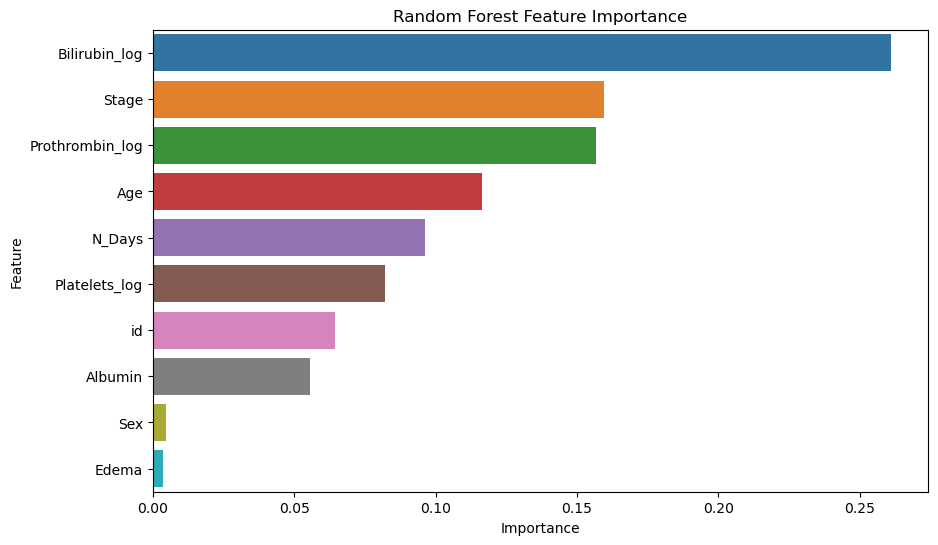

In [ ]:
# Get feature importances
rf_best = rs.best_estimator_
importances = rf_best.feature_importances_
features = X_res.columns  # assuming your features are in a DataFrame

# Create a DataFrame for sorting
feat_imp_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values(by="Importance", ascending=False)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x="Importance", y="Feature", data=feat_imp_df.head(15))  # top 15 features
plt.title("Random Forest Feature Importance")
plt.show()

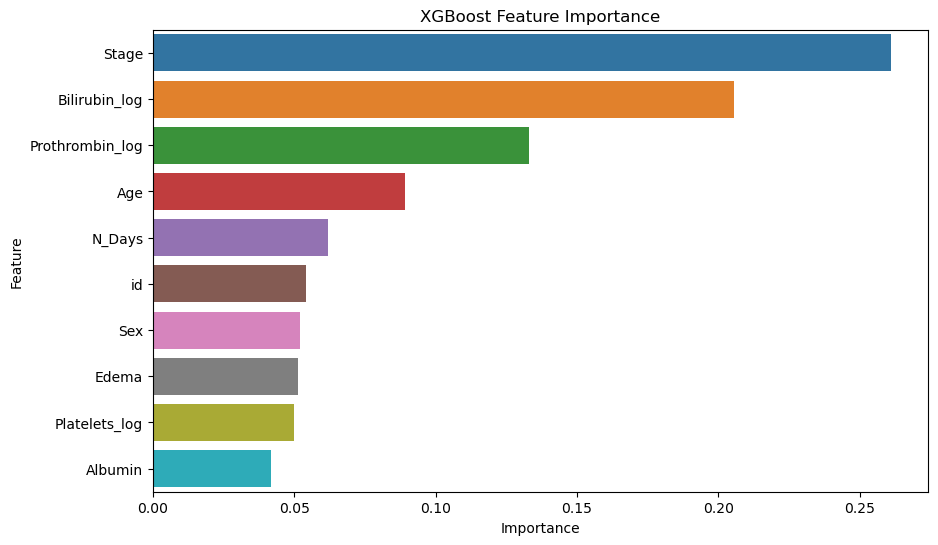

In [71]:

# Get feature importances from the best XGBoost model
xgb_best = rs1.best_estimator_ 
importances = xgb_best.feature_importances_
features = X_res.columns  # assuming your features are in a DataFrame

# Create DataFrame
feat_imp_xgb = pd.DataFrame({'Feature': features, 'Importance': importances})
feat_imp_xgb = feat_imp_xgb.sort_values(by="Importance", ascending=False)

# Plot top 15 features
plt.figure(figsize=(10,6))
sns.barplot(x="Importance", y="Feature", data=feat_imp_xgb.head(15))
plt.title("XGBoost Feature Importance")
plt.show()


Test

In [69]:
test = pd.read_csv('test.csv')
test

,id,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,15000,708.0,NaN,18628.0,F,NaN,NaN,NaN,N,3.2,NaN,3.15,NaN,NaN,NaN,NaN,388.0,9.9,3.0
1,15001,971.0,Placebo,19470.0,F,N,N,Y,N,20.0,1276.0,3.04,141.0,2496.0,203.05,157.0,319.0,12.9,4.0
2,15002,1427.0,D-penicillamine,11872.0,F,N,N,N,N,0.5,257.0,3.74,37.0,9009.8,127.00,73.0,283.0,10.4,2.0
3,15003,1097.0,NaN,18993.0,F,NaN,NaN,NaN,N,1.8,NaN,3.20,NaN,NaN,NaN,NaN,117.0,10.7,2.0
4,15004,2103.0,NaN,22797.0,F,NaN,NaN,NaN,S,0.9,NaN,3.75,NaN,NaN,NaN,NaN,226.0,9.9,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,24995,1022.0,NaN,13514.0,F,NaN,NaN,NaN,N,0.5,NaN,3.93,NaN,NaN,NaN,NaN,312.0,10.8,2.0
9996,24996,1677.0,Placebo,17233.0,F,N,Y,Y,N,1.0,266.0,3.70,39.0,1162.0,75.95,102.0,244.0,11.0,4.0
9997,24997,3823.0,D-penicillamine,10550.0,F,N,N,N,N,0.9,233.0,3.93,20.0,646.0,66.65,68.0,206.0,11.0,2.0
9998,24998,552.0,Placebo,20442.0,F,N,Y,N,N,2.3,227.0,3.06,76.0,1141.0,221.88,90.0,216.0,11.5,4.0


In [72]:
#drop the columsn with alot of missing values and those that are not needed for the analysis
test.drop(['Drug', 'Ascites', 'Hepatomegaly', 'Spiders', 'Cholesterol', 'Copper','Alk_Phos', 'SGOT','Tryglicerides'], axis=1, inplace=True)

In [76]:
#fill the missing values with the median of each column
test['Platelets'].fillna(test['Platelets'].median(), inplace=True)
test['Prothrombin'].fillna(test['Prothrombin'].median(), inplace=True)

In [79]:
#convert the age column to years for better understanding
test['Age'] = test['Age'] / 365
test['Age'] = test['Age'].round(1)

In [81]:
#check for outliers in the age column
q1 = test['Age'].quantile(0.25)
q3 = test['Age'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr 
outliers = test[(test['Age'] < lower_bound) | (test['Age'] > upper_bound)]
outliers

,id,N_Days,Age,Sex,Edema,Bilirubin,Albumin,Platelets,Prothrombin,Stage
1191,16191,1150.0,5.9,F,N,0.6,3.42,340.0,10.9,1.0
1512,16512,1223.0,3.4,F,N,0.7,3.62,255.0,10.8,3.0
1965,16965,3445.0,9.4,F,N,2.0,3.70,234.0,11.0,2.0
2928,17928,2990.0,8.2,F,N,0.7,3.00,311.0,10.7,3.0
3171,18171,2990.0,8.2,M,N,6.1,3.36,304.0,10.3,2.0
3257,18257,2224.0,5.2,F,N,0.6,3.40,298.0,10.0,3.0
3728,18728,3468.0,9.5,F,S,0.9,3.81,174.0,11.0,4.0
4810,19810,2995.0,8.2,F,N,0.9,3.70,213.0,9.6,3.0
5267,20267,3913.0,9.7,F,N,0.9,3.93,474.0,10.6,2.0
5355,20355,4062.0,10.6,F,N,0.9,3.65,388.0,10.4,4.0


In [82]:
#filter out the outliers in the age column i.e age less than 10 years and greater than 120 years
test = test[(test['Age'] >= 10.0) & (test['Age'] <= 120.0)]

In [84]:
#log transformations for the clinical results to reduce skewness
test['Bilirubin_log'] = np.log1p(test['Bilirubin'])
test['Prothrombin_log'] = np.log1p(test['Prothrombin'])
test['Platelets_log'] = np.log1p(test['Platelets'])

In [86]:
#drop the original columns after log transformation
test= test.drop(columns=['Bilirubin', 'Prothrombin', 'Platelets'], axis=1)

In [88]:
#encoding for categorical variables
test['Edema'] = test['Edema'].map({'N': 0, 'S': 1, 'Y': 2})

In [90]:
#encode the sex column
test['Sex'] = test['Sex'].map({'M': 0, 'F': 1})

In [92]:
#scale the data
num_col = ['N_Days','Age', 'Bilirubin_log', 'Albumin', 'Prothrombin_log', 'Platelets_log']
scaler = StandardScaler()
test[num_col] = scaler.fit_transform(test[num_col])

In [99]:
X_test = test.copy()

# Get class probabilities instead of just predicted label
y_proba = rs1.predict_proba(X_test)

# Put results into a DataFrame
predictions= pd.DataFrame({
    "id": test["id"],                
    "status_C": y_proba[:, 0],       # probability of class 0
    "status_D": y_proba[:, 1],       # probability of class 1
    "status_CL": y_proba[:, 2]       # probability of class 2
})

In [100]:
predictions

,id,status_C,status_D,status_CL
0,15000,0.887649,0.107381,0.004969
1,15001,0.996529,0.000592,0.002879
2,15002,0.003795,0.000993,0.995212
3,15003,0.888677,0.002716,0.108607
4,15004,0.189815,0.000142,0.810043
...,...,...,...,...
9995,24995,0.012963,0.014995,0.972042
9996,24996,0.739889,0.000395,0.259716
9997,24997,0.040592,0.002922,0.956486
9998,24998,0.998794,0.000079,0.001127
